In [1]:
import numpy as np
import torch
import scanpy as sc
from data import PertDataloader, Network


model_name = 'GNN_Disentangle_GAT_string_20.0_64_2_l3_Norman2019_gamma2_gene_emb_pert_emb_constant_lambda_emission'
args = np.load('./saved_args/'+model_name+'.npy', allow_pickle = True).item()
args['device'] = 'cuda:4'

In [2]:
if args['network_name'] == 'string':
    args['network_path'] = '/dfs/project/perturb-gnn/graphs/STRING_full_9606.csv'

if args['dataset'] == 'Norman2019':
    data_path = '/dfs/project/perturb-gnn/datasets/Norman2019_hvg+perts.h5ad'

adata = sc.read_h5ad(data_path)
if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
gene_list = [f for f in adata.var.gene_symbols.values]
# Set up message passing network
network = Network(fname=args['network_path'], gene_list=args['gene_list'],
                  percentile=args['top_edge_percent'])

# Pertrubation dataloader
pertdl = PertDataloader(adata, network.G, network.weights, args)

There are 101013 edges in the PPI.
Creating pyg object for each cell in the data...
Local copy of pyg dataset is detected. Loading...
Loading splits...
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Creating dataloaders....
Dataloaders created...


In [3]:
model = torch.load('./saved_models/' + model_name)
#model.pert_emb_agg = 'constant'
#model.lambda_emission = False
model.sim_gnn = False
model.args = args
from inference import evaluate, compute_metrics

test_res = evaluate(pertdl.loaders['test_loader'],
                        pertdl.loaders['edge_index'],
                        pertdl.loaders['edge_attr'], model, args)

test_metrics, test_pert_res = compute_metrics(test_res)

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/dfs/user/kexinh/miniconda3/

In [54]:
pert2pert_full_id = dict(adata.obs[['condition', 'cov_drug_dose_name']].values)
geneid2name = dict(zip(adata.var.index.values, adata.var['gene_name']))
de_names = [geneid2name[i] for i in adata.uns['rank_genes_groups_cov'][pert2pert_full_id[pert]]]

In [32]:
import seaborn as sns

In [86]:
sns.set(rc={'figure.figsize':(6, 2)})

def analyze(pert):

    print(pert)
    print(pert2group[pert])
    for i,j in test_pert_res[pert].items():
        if i[-2:] == 'de':
            print(i + ': ' + str(j))

    pert2pert_full_id = dict(adata.obs[['condition', 'cov_drug_dose_name']].values)
    geneid2name = dict(zip(adata.var.index.values, adata.var['gene_name']))
    de_names = [geneid2name[i] for i in adata.uns['rank_genes_groups_cov'][pert2pert_full_id[pert]]]

    pert_idx = np.where(test_res['pert_cat'] == pert)[0]
    pred_mean = np.mean(test_res['pred_de'][pert_idx], axis = 0).reshape(-1,)
    true_mean = np.mean(test_res['truth_de'][pert_idx], axis = 0).reshape(-1,)
    ax = sns.heatmap(np.vstack((true_mean.reshape(1,-1), pred_mean.reshape(1,-1))))
    t = ax.set_yticklabels(['True', 'Predicted'])
    t = ax.set_xticklabels(de_names, rotation = 90)

    mean = np.mean(test_res['truth_de'][pert_idx], axis = 0)
    std = np.std(test_res['truth_de'][pert_idx], axis = 0)
    min_ = np.min(test_res['truth_de'][pert_idx], axis = 0)
    max_ = np.max(test_res['truth_de'][pert_idx], axis = 0)

    in_range = (pred_mean >= min_) & (pred_mean <= max_)
    frac_in_range = sum(in_range)/20
    print(str(frac_in_range * 100) + '% of genes in the range')
    if frac_in_range != 1:
        false_ = np.where(in_range == False)[0]
        print('not in range genes:' + str(np.array(de_names)[false_]))
    
    zero_idx = np.where(std > 0)[0]
    print('there are ' + str(20 - len(zero_idx)) + ' genes with zero stds, removing them for calculation...')
    sigma = (np.abs(pred_mean[zero_idx] - mean[zero_idx]))/(std[zero_idx])
    print('average sigma: ' + str(np.mean(sigma)))
    print('frac of below 1 sigma: ' + str(1 - len(np.where(sigma > 1)[0])/len(zero_idx)))
    print('frac of below 2 sigma: ' + str(1 - len(np.where(sigma > 2)[0])/len(zero_idx)))
    print('above 2 sigma genes:' + str(np.array(de_names)[zero_idx][np.where(sigma > 2)[0]]))

In [678]:
def deeper_analysis(adata, test_res, pert_metric):
    metric2fct = {
           'spearman': spearmanr,
           'pearson': pearsonr
    }
    
    #pert_metric = {}
    
    ## in silico modeling and upperbounding
    pert2pert_full_id = dict(adata.obs[['condition', 'cov_drug_dose_name']].values)
    geneid2name = dict(zip(adata.var.index.values, adata.var['gene_name']))
    geneid2idx = dict(zip(adata.var.index.values, range(len(adata.var.index.values))))
    
    # calculate mean expression for each condition
    unique_conditions = adata.obs.condition.unique()
    conditions2index = {}
    for i in unique_conditions:
        conditions2index[i] = np.where(adata.obs.condition == i)[0]

    condition2mean_expression = {}
    for i, j in conditions2index.items():
        condition2mean_expression[i] = np.mean(adata.X[j], axis = 0)
    pert_list = np.array(list(condition2mean_expression.keys()))
    mean_expression = np.array(list(condition2mean_expression.values())).reshape(len(adata.obs.condition.unique()), adata.X.toarray().shape[1])
    ctrl = mean_expression[np.where(pert_list == 'ctrl')[0]]
    most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]
    gene_list = adata.var['gene_name'].values
    
    for pert in np.unique(test_res['pert_cat']):
        #pert_metric[pert] = {}
        #de_names = [geneid2name[i] for i in adata.uns['rank_genes_groups_cov'][pert2pert_full_id[pert]]]
        de_idx = [geneid2idx[i] for i in adata.uns['rank_genes_groups_cov'][pert2pert_full_id[pert]]]
        
        pert_idx = np.where(test_res['pert_cat'] == pert)[0]
        pred_mean = np.mean(test_res['pred_de'][pert_idx], axis = 0).reshape(-1,)
        true_mean = np.mean(test_res['truth_de'][pert_idx], axis = 0).reshape(-1,)
        
        mean = np.mean(test_res['truth_de'][pert_idx], axis = 0)
        std = np.std(test_res['truth_de'][pert_idx], axis = 0)
        min_ = np.min(test_res['truth_de'][pert_idx], axis = 0)
        max_ = np.max(test_res['truth_de'][pert_idx], axis = 0)
        zero_des = np.intersect1d(np.where(min_ == 0)[0], np.where(max_ == 0)[0])
        nonzero_des = np.setdiff1d(list(range(20)), zero_des)
        if len(nonzero_des) == 0:
            pass
            # there should be some errors in selecting DEs for this pert
        else:
            in_range = (pred_mean[nonzero_des] >= min_[nonzero_des]) & (pred_mean[nonzero_des] <= max_[nonzero_des])
            frac_in_range = sum(in_range)/len(nonzero_des)
            pert_metric[pert]['frac_in_range'] = frac_in_range

            zero_idx = np.where(std > 0)[0]
            sigma = (np.abs(pred_mean[zero_idx] - mean[zero_idx]))/(std[zero_idx])
            pert_metric[pert]['mean_sigma'] = np.mean(sigma)
            pert_metric[pert]['std_sigma'] = np.std(sigma)
            pert_metric[pert]['frac_sigma_below_1'] = 1 - len(np.where(sigma > 1)[0])/len(zero_idx)
            pert_metric[pert]['frac_sigma_below_2'] = 1 - len(np.where(sigma > 2)[0])/len(zero_idx)

        ## correlation on delta
        p_idx = np.where(test_res['pert_cat'] == pert)[0]

        for m, fct in metric2fct.items():
            val = fct(test_res['pred'][p_idx].mean(0)- ctrl[0], test_res['truth'][p_idx].mean(0)-ctrl[0])[0]
            if np.isnan(val):
                val = 0

            pert_metric[pert][m + '_delta'] = val
            
            val = fct(test_res['pred_de'][p_idx].mean(0)- ctrl[0][de_idx], test_res['truth_de'][p_idx].mean(0)-ctrl[0][de_idx])[0]
            if np.isnan(val):
                val = 0

            pert_metric[pert][m + '_delta_de'] = val
        
        ## up fold changes > 10?
        pert_mean = np.mean(test_res['truth'][p_idx], axis = 0).reshape(-1,)
        
        fold_change = pert_mean/ctrl
        fold_change[np.isnan(fold_change)] = 0
        fold_change[np.isinf(fold_change)] = 0
        ## this is to remove the ones that are super low and the fold change becomes unmeaningful
        fold_change[0][np.where(pert_mean < 0.5)[0]] = 0
        
        o =  np.where(fold_change[0] > 0)[0]
        
        pred_fc = test_res['pred'][p_idx].mean(0)[o]
        true_fc = test_res['truth'][p_idx].mean(0)[o]
        ctrl_fc = ctrl[0][o]
        
        if len(o) > 0:
            pert_metric[pert]['fold_change_gap_all'] = np.mean(np.abs(pred_fc/ctrl_fc - true_fc/ctrl_fc))
        
        
        o = np.intersect1d(np.where(fold_change[0] <0.333)[0], np.where(fold_change[0] > 0)[0])
        
        pred_fc = test_res['pred'][p_idx].mean(0)[o]
        true_fc = test_res['truth'][p_idx].mean(0)[o]
        ctrl_fc = ctrl[0][o]
        
        if len(o) > 0:
            pert_metric[pert]['fold_change_gap_downreg_0.33'] = np.mean(np.abs(pred_fc/ctrl_fc - true_fc/ctrl_fc))
        
        
        o = np.intersect1d(np.where(fold_change[0] <0.1)[0], np.where(fold_change[0] > 0)[0])
        
        pred_fc = test_res['pred'][p_idx].mean(0)[o]
        true_fc = test_res['truth'][p_idx].mean(0)[o]
        ctrl_fc = ctrl[0][o]
        
        if len(o) > 0:
            pert_metric[pert]['fold_change_gap_downreg_0.1'] = np.mean(np.abs(pred_fc/ctrl_fc - true_fc/ctrl_fc))

        o = np.where(fold_change[0] > 3)[0]
        
        pred_fc = test_res['pred'][p_idx].mean(0)[o]
        true_fc = test_res['truth'][p_idx].mean(0)[o]
        ctrl_fc = ctrl[0][o]
        
        if len(o) > 0:
            pert_metric[pert]['fold_change_gap_upreg_3'] = np.mean(np.abs(pred_fc/ctrl_fc - true_fc/ctrl_fc))
        
        o = np.where(fold_change[0] > 10)[0]
        
        pred_fc = test_res['pred'][p_idx].mean(0)[o]
        true_fc = test_res['truth'][p_idx].mean(0)[o]
        ctrl_fc = ctrl[0][o]
        
        if len(o) > 0:
            pert_metric[pert]['fold_change_gap_upreg_10'] = np.mean(np.abs(pred_fc/ctrl_fc - true_fc/ctrl_fc))

        ## most variable genes
        for m, fct in metric2fct.items():
            val = fct(test_res['pred'][p_idx].mean(0)[most_variable_genes] - ctrl[0][most_variable_genes], test_res['truth'][p_idx].mean(0)[most_variable_genes]-ctrl[0][most_variable_genes])[0]
            if np.isnan(val):
                val = 0
            pert_metric[pert][m + '_delta_top200_hvg'] = val

            
            val = fct(test_res['pred'][p_idx].mean(0)[most_variable_genes], test_res['truth'][p_idx].mean(0)[most_variable_genes])[0]
            if np.isnan(val):
                val = 0
            pert_metric[pert][m + '_top200_hvg'] = val

    return pert_metric


def GI_subgroup(pert_metric):
    GI_type2Score = {}
    test_pert_list = list(pert_metric.keys())
    for GI_type, gi_list in GIs.items():
        intersect = np.intersect1d(gi_list, test_pert_list)
        if len(intersect) != 0:
            GI_type2Score[GI_type] = {}

            for m in list(list(pert_metric.values())[0].keys()):
                GI_type2Score[GI_type][m] = np.mean([pert_metric[i][m] for i in intersect if m in pert_metric[i]])
                
    return GI_type2Score

In [679]:
out = deeper_analysis(adata, test_res, test_pert_res)
GI_subgroup(out)

/tmp/ipykernel_50634/3442456188.py:78: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/tmp/ipykernel_50634/3442456188.py:78: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl


{'NEOMORPHIC': {'frac_in_range': 1.0,
  'mean_sigma': 1.0047382,
  'std_sigma': 1.1187395,
  'frac_sigma_below_1': 0.7223691377135649,
  'frac_sigma_below_2': 0.9016311202843711,
  'spearman_delta': 0.022592210321319722,
  'spearman_delta_de': 0.7563909774436091,
  'pearson_delta': 0.34982917961411514,
  'pearson_delta_de': 0.7690294987989904,
  'fold_change_gap_all': 0.17500299,
  'fold_change_gap_upreg_3': 5.0310636,
  'spearman_delta_top200_hvg': 0.5028838220955525,
  'spearman_top200_hvg': 0.9324448146428421,
  'pearson_delta_top200_hvg': 0.460737114491091,
  'pearson_top200_hvg': 0.9554292688818604},
 'ADDITIVE': {'frac_in_range': 1.0,
  'mean_sigma': 0.8927701,
  'std_sigma': 0.6198561,
  'frac_sigma_below_1': 0.6602274681802546,
  'frac_sigma_below_2': 0.9548976608187134,
  'spearman_delta': 0.15960641444954182,
  'spearman_delta_de': 0.8735171261487049,
  'pearson_delta': 0.5106381738818909,
  'pearson_delta_de': 0.9024134469888412,
  'fold_change_gap_all': 0.2688549,
  'fold_c

In [680]:
out

{'AHR+KLF1': {'frac_in_range': 1.0,
  'mean_sigma': 0.8931963,
  'std_sigma': 1.6403185,
  'frac_sigma_below_1': 0.8,
  'frac_sigma_below_2': 0.9,
  'spearman_delta': 0.024240095098284783,
  'spearman_delta_de': 0.9428571428571428,
  'pearson_delta': 0.27795797329465494,
  'pearson_delta_de': 0.9468511331540121,
  'fold_change_gap_all': 0.20037927,
  'fold_change_gap_upreg_3': 1.1235406,
  'spearman_delta_top200_hvg': 0.17930548263706597,
  'spearman_top200_hvg': 0.9407395184879624,
  'pearson_delta_top200_hvg': 0.3861890660215789,
  'pearson_top200_hvg': 0.94319804209089},
 'ARID1A+ctrl': {'frac_in_range': 1.0,
  'mean_sigma': 1.14268,
  'std_sigma': 0.9115124,
  'frac_sigma_below_1': 0.5714285714285714,
  'frac_sigma_below_2': 0.8571428571428572,
  'spearman_delta': 0.07556004638719059,
  'spearman_delta_de': 0.9263157894736842,
  'pearson_delta': 0.4506821097122015,
  'pearson_delta_de': 0.9732283269712433,
  'fold_change_gap_all': 0.18486646,
  'fold_change_gap_upreg_3': 2.9545946,

AHR+KLF1
combo_seen2
mse_de: 0.2098773
mae_de: 0.3267787
spearman_de: 0.7969924812030074
pearson_de: 0.9219436194773751
r2_de: 0.6219090845186681
100.0% of genes in the range
there are 0 genes with zero stds, removing them for calculation...
average sigma: 0.8931963
frac of below 1 sigma: 0.8
frac of below 2 sigma: 0.9
above 2 sigma genes:['HBA1' 'LGALS1']


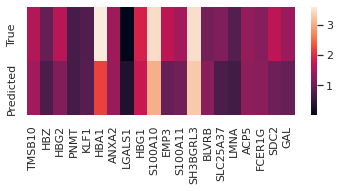

In [88]:
analyze(list(test_pert_res.keys())[i])
i+=1

ARID1A+ctrl
unseen_single
mse_de: 0.2253922
mae_de: 0.41007867
spearman_de: 0.9151289674603723
pearson_de: 0.9333854539097096
r2_de: 0.7934088507702576
70.0% of genes in the range
not in range genes:['TUBB2B' 'SEMA6B' 'TEX30' 'KCNH2' 'DDX21' 'PRDX1']
there are 6 genes with zero stds, removing them for calculation...
average sigma: 1.14268
frac of below 1 sigma: 0.5714285714285714
frac of below 2 sigma: 0.8571428571428572
above 2 sigma genes:['TMSB10' 'VIM']


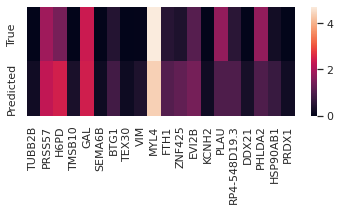

In [89]:
analyze(list(test_pert_res.keys())[i])
i+=1

BCL2L11+BAK1
combo_seen1
mse_de: 0.028922627
mae_de: 0.16328989
spearman_de: 0.37796447300922725
pearson_de: 0.9864382692780493
r2_de: -1.2911260202751471
5.0% of genes in the range
not in range genes:['ECM1' 'IKZF2' 'BISPR' 'NOX5' 'LINC01305' 'IFI30' 'CTSL' 'ABTB1' 'PTH2'
 'RP11-212I21.4' 'TESK2' 'LPXN' 'POLD4' 'RASGRP3' 'ICOSLG' 'EPB42'
 'RP11-1398P2.1' 'RP11-355B11.2' 'PRRT2']
there are 19 genes with zero stds, removing them for calculation...
average sigma: 0.84067315
frac of below 1 sigma: 1.0
frac of below 2 sigma: 1.0
above 2 sigma genes:[]


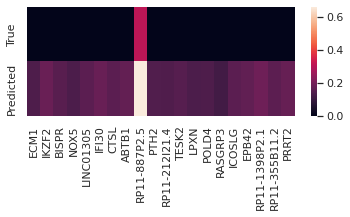

In [90]:
analyze(list(test_pert_res.keys())[i])
i+=1

BCL2L11+TGFBR2
combo_seen1
mse_de: 0.055616103
mae_de: 0.22110891
spearman_de: 0.9841579505977515
pearson_de: 0.9765927375871464
r2_de: 0.9023527544836009
80.0% of genes in the range
not in range genes:['TMSB10' 'IRF7' 'MT1G' 'LCA5']
there are 4 genes with zero stds, removing them for calculation...
average sigma: 0.5360814
frac of below 1 sigma: 0.9375
frac of below 2 sigma: 1.0
above 2 sigma genes:[]


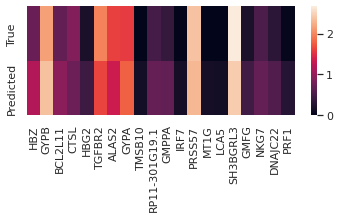

In [91]:
analyze(list(test_pert_res.keys())[i])
i+=1

BCL2L11+ctrl
unseen_single
mse_de: 0.023406755
mae_de: 0.14449443
spearman_de: 0.5209880722517277
pearson_de: 0.9819634019972169
r2_de: 0.8150883400623465
10.0% of genes in the range
not in range genes:['BCL2L11' 'GYPB' 'SLC2A6' 'MCEMP1' 'LOXL2' 'ACSL5' 'NFASC' 'CTB-13F3.1'
 'RP3-406P24.3' 'RP11-55K13.1' 'RP5-1024G6.5' 'CLNK' 'EWSAT1' 'SLC15A2'
 'RP11-421M1.8' 'C1orf228' 'MMP9' 'OTUD1']
there are 18 genes with zero stds, removing them for calculation...
average sigma: 0.39766482
frac of below 1 sigma: 1.0
frac of below 2 sigma: 1.0
above 2 sigma genes:[]


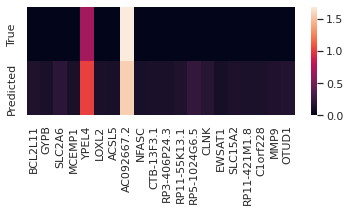

In [92]:
analyze(list(test_pert_res.keys())[i])
i+=1

BCORL1+ctrl
unseen_single
mse_de: 0.1045298
mae_de: 0.26133913
spearman_de: 0.9259582676757693
pearson_de: 0.9626769366133556
r2_de: 0.88615513999374
60.0% of genes in the range
not in range genes:['KRT18' 'GAL' 'FEV' 'KRT8' 'RP11-160O5.1' 'ARHGEF26' 'TP53INP2' 'SEMA3B']
there are 8 genes with zero stds, removing them for calculation...
average sigma: 0.89024395
frac of below 1 sigma: 0.5
frac of below 2 sigma: 1.0
above 2 sigma genes:[]


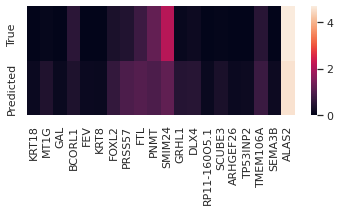

In [93]:
analyze(list(test_pert_res.keys())[i])
i+=1

In [97]:
adata.var

,gene_name,mean,std,cv,fano,in_matrix,highly_variable,means,dispersions,dispersions_norm,gene_symbols
gene_id,,,,,,,,,,,
ENSG00000239945,RP11-34P13.8,0.000085,0.009242,108.196003,0.999925,True,True,0.000145,0.837956,1.663704,RP11-34P13.8
ENSG00000223764,RP11-54O7.3,0.007912,0.091792,11.602000,1.064974,True,True,0.009702,0.547203,0.776219,RP11-54O7.3
ENSG00000187634,SAMD11,0.021280,0.167784,7.884765,1.322939,True,True,0.028434,0.937234,1.966738,SAMD11
ENSG00000187642,PERM1,0.000149,0.012225,81.785870,0.999861,True,True,0.000212,0.538653,0.750123,PERM1
ENSG00000188290,HES4,0.349986,0.699442,1.998485,1.397825,True,True,0.285414,0.483443,0.663183,HES4
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198786,MT-ND5,8.054528,4.540736,0.563749,2.559837,True,True,2.207500,0.953207,0.605198,MT-ND5
ENSG00000198695,MT-ND6,4.522379,4.105639,0.907849,3.727301,True,True,1.666242,1.267892,4.019786,MT-ND6
ENSG00000198727,MT-CYB,42.826667,19.762921,0.461463,9.119856,True,True,3.775564,1.874488,0.820883,MT-CYB


In [683]:
import scanpy as sc
import pandas as pd

def rank_genes_groups_by_cov(
    adata,
    groupby,
    control_group,
    covariate,
    pool_doses=False,
    n_genes=50,
    rankby_abs=True,
    key_added='rank_genes_groups_cov',
    return_dict=False,
):

    """
    Function that generates a list of differentially expressed genes computed
    separately for each covariate category, and using the respective control
    cells as reference.

    Usage example:

    rank_genes_groups_by_cov(
        adata,
        groupby='cov_product_dose',
        covariate_key='cell_type',
        control_group='Vehicle_0'
    )

    Parameters
    ----------
    adata : AnnData
        AnnData dataset
    groupby : str
        Obs column that defines the groups, should be
        cartesian product of covariate_perturbation_cont_var,
        it is important that this format is followed.
    control_group : str
        String that defines the control group in the groupby obs
    covariate : str
        Obs column that defines the main covariate by which we
        want to separate DEG computation (eg. cell type, species, etc.)
    n_genes : int (default: 50)
        Number of DEGs to include in the lists
    rankby_abs : bool (default: True)
        If True, rank genes by absolute values of the score, thus including
        top downregulated genes in the top N genes. If False, the ranking will
        have only upregulated genes at the top.
    key_added : str (default: 'rank_genes_groups_cov')
        Key used when adding the dictionary to adata.uns
    return_dict : str (default: False)
        Signals whether to return the dictionary or not

    Returns
    -------
    Adds the DEG dictionary to adata.uns

    If return_dict is True returns:
    gene_dict : dict
        Dictionary where groups are stored as keys, and the list of DEGs
        are the corresponding values

    """

    gene_dict = {}
    cov_categories = adata.obs[covariate].unique()
    for cov_cat in cov_categories:
        print(cov_cat)
        #name of the control group in the groupby obs column
        control_group_cov = '_'.join([cov_cat, control_group])

        #subset adata to cells belonging to a covariate category
        adata_cov = adata[adata.obs[covariate]==cov_cat]

        #compute DEGs
        sc.tl.rank_genes_groups(
            adata_cov,
            groupby=groupby,
            reference=control_group_cov,
            rankby_abs=rankby_abs,
            n_genes=n_genes
        )

        #add entries to dictionary of gene sets
        de_genes = pd.DataFrame(adata_cov.uns['rank_genes_groups']['names'])
        for group in de_genes:
            gene_dict[group] = de_genes[group].tolist()

    adata.uns[key_added] = gene_dict

    if return_dict:
        return gene_dict



In [684]:
rank_genes_groups_by_cov(adata, 
                         groupby='cov_drug_dose_name', 
                         covariate='cell_type', 
                         control_group='ctrl_1', 
                         n_genes=200,
                         key_added = 'rank_genes_groups_cov_top200')

A549


Trying to set attribute `.uns` of view, copying.
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-pa

In [685]:
rank_genes_groups_by_cov(adata, 
                         groupby='cov_drug_dose_name', 
                         covariate='cell_type', 
                         control_group='ctrl_1', 
                         n_genes=100,
                         key_added = 'rank_genes_groups_cov_top100')

A549


Trying to set attribute `.uns` of view, copying.


In [688]:
adata.write_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019_hvg+perts_more_de.h5ad')

In [98]:
GIs = {
    'NEOMORPHIC': ['CBL+TGFBR2',
                  'KLF1+TGFBR2',
                  'MAP2K6+SPI1',
                  'SAMD1+TGFBR2',
                  'TGFBR2+CBARP',
                  'TGFBR2+ETS2',
                  'CBL+UBASH3A',
                  'CEBPE+KLF1',
                  'DUSP9+MAPK1',
                  'FOSB+PTPN12',
                  'PLK4+STIL',
                  'PTPN12+OSR2',
                  'ZC3HAV1+CEBPE'],
    'ADDITIVE': ['BPGM+SAMD1',
                'CEBPB+MAPK1',
                'CEBPE+OSR2',
                'DUSP9+PRTG',
                'FOSB+OSR2',
                'IRF1+SET',
                'MAP2K3+ELMSAN1',
                'MAP2K6+ELMSAN1',
                'POU3F2+FOXL2',
                'RHOXF2B+SET',
                'SAMD1+PTPN12',
                'SAMD1+UBASH3B',
                'SAMD1+ZBTB1',
                'SGK1+TBX2',
                'TBX3+TBX2',
                'ZBTB10+SNAI1'],
    'EPISTASIS': ['AHR+KLF1',
                 'MAPK1+TGFBR2',
                 'TGFBR2+IGDCC3',
                 'TGFBR2+PRTG',
                 'UBASH3B+OSR2',
                 'DUSP9+ETS2',
                 'KLF1+CEBPA',
                 'MAP2K6+IKZF3',
                 'ZC3HAV1+CEBPA'],
    'REDUNDANT': ['CDKN1C+CDKN1A',
                 'MAP2K3+MAP2K6',
                 'CEBPB+CEBPA',
                 'CEBPE+CEBPA',
                 'CEBPE+SPI1',
                 'ETS2+MAPK1',
                 'FOSB+CEBPE',
                 'FOXA3+FOXA1'],
    'POTENTIATION': ['CNN1+UBASH3A',
                    'ETS2+MAP7D1',
                    'FEV+CBFA2T3',
                    'FEV+ISL2',
                    'FEV+MAP7D1',
                    'PTPN12+UBASH3A'],
    'SYNERGY_SIMILAR_PHENO':['CBL+CNN1',
                            'CBL+PTPN12',
                            'CBL+PTPN9',
                            'CBL+UBASH3B',
                            'FOXA3+FOXL2',
                            'FOXA3+HOXB9',
                            'FOXL2+HOXB9',
                            'UBASH3B+CNN1',
                            'UBASH3B+PTPN12',
                            'UBASH3B+PTPN9',
                            'UBASH3B+ZBTB25'],
    'SYNERGY_DISSIMILAR_PHENO': ['AHR+FEV',
                                'DUSP9+SNAI1',
                                'FOXA1+FOXF1',
                                'FOXA1+FOXL2',
                                'FOXA1+HOXB9',
                                'FOXF1+FOXL2',
                                'FOXF1+HOXB9',
                                'FOXL2+MEIS1',
                                'IGDCC3+ZBTB25',
                                'POU3F2+CBFA2T3',
                                'PTPN12+ZBTB25',
                                'SNAI1+DLX2',
                                'SNAI1+UBASH3B'],
    'SUPPRESSOR': ['CEBPB+PTPN12',
                  'CEBPE+CNN1',
                  'CEBPE+PTPN12',
                  'CNN1+MAPK1',
                  'ETS2+CNN1',
                  'ETS2+IGDCC3',
                  'ETS2+PRTG',
                  'FOSB+UBASH3B',
                  'IGDCC3+MAPK1',
                  'LYL1+CEBPB',
                  'MAPK1+PRTG',
                  'PTPN12+SNAI1']
}

In [99]:
import pickle
pickle.dump(GIs, open('GIs.pkl', 'wb'))

In [546]:
GI_type2Score = {}
test_pert_list = list(test_pert_res.keys())
for GI_type, gi_list in GIs.items():
    intersect = np.intersect1d(gi_list, test_pert_list)
    if len(intersect) != 0:
        GI_type2Score[GI_type] = {}
        for metric in ['mse_de','mae_de','spearman_de','pearson_de']:
            GI_type2Score[GI_type][metric] = np.mean([test_pert_res[i][metric] for i in intersect])
        GI_type2Score[GI_type]['spearman_delta'] = np.mean([metrics_pert_delta[i]['spearman'] for i in intersect])
        GI_type2Score[GI_type]['pearson_delta'] = np.mean([metrics_pert_delta[i]['pearson'] for i in intersect])
    

In [547]:
GI_type2Score

{'NEOMORPHIC': {'mse_de': 0.12941988,
  'mae_de': 0.2903899,
  'spearman_de': 0.6574643750743108,
  'pearson_de': 0.697350411647083,
  'spearman_delta': 0.022592210321319722,
  'pearson_delta': 0.34982917961411514},
 'ADDITIVE': {'mse_de': 0.28212306,
  'mae_de': 0.43237478,
  'spearman_de': 0.7879227954680315,
  'pearson_de': 0.8333688993592533,
  'spearman_delta': 0.15960641444954182,
  'pearson_delta': 0.5106381738818909},
 'EPISTASIS': {'mse_de': 0.2625154,
  'mae_de': 0.413961,
  'spearman_de': 0.8300751879699246,
  'pearson_de': 0.9206864497015774,
  'spearman_delta': 0.1072512672293257,
  'pearson_delta': 0.30971756784836724},
 'REDUNDANT': {'mse_de': 0.31345636,
  'mae_de': 0.4750586,
  'spearman_de': 0.7026792879480943,
  'pearson_de': 0.8941020217427124,
  'spearman_delta': 0.21046216592541714,
  'pearson_delta': 0.6227420958050749},
 'POTENTIATION': {'mse_de': 0.38493425,
  'mae_de': 0.53428775,
  'spearman_de': 0.8975669402689463,
  'pearson_de': 0.8984220776899547,
  'spea

In [106]:
import pandas as pd
df_pert_status = pd.read_excel('./perturbation_status.xlsx')[['gene_name', 'gene type']]

In [108]:
df_pert_status['gene type'].value_counts()

transcription factor          49
signaling                     21
metabolism                     5
mitotic spindle                5
solute channel                 4
poorly characterized           3
extracellular matrix           3
CDK inhibitor                  3
chromatin remodeling           2
immunoglobulin DCC subtype     2
BCL2 family pro-apoptotic      2
RNA binding                    1
actin/calcium binding          1
metal ion binding              1
ubiquitin ligase               1
ribosome maturation            1
cytoskeleton                   1
Name: gene type, dtype: int64

In [109]:
df_pert_status = df_pert_status[df_pert_status['gene type'] != 'poorly characterized']

In [111]:
df_pert_status.to_csv('gene2type.csv', index = False)

In [156]:
gene2status = dict(df_pert_status.values)

In [170]:
form_AB_C = [('BCL2L11+BAK1', 'MAML2+ctrl', 0.3523299818794149),
 ('BCL2L11+TGFBR2', 'ctrl+PRTG', 0.6857607274776449),
 ('CDKN1C+CDKN1B', 'CDKN1A+ctrl', 0.8779019780110475),
 ('CEBPB+MAPK1', 'ctrl+ETS2', 0.8337438300302283),
 ('CEBPE+CEBPB', 'CEBPA+ctrl', 0.9459044940236668),
 ('CEBPE+CEBPB', 'ctrl+CEBPA', 0.9450568814100481),
 ('CEBPE+SPI1', 'CEBPA+ctrl', 0.9265882308117831),
 ('CEBPE+SPI1', 'ctrl+CEBPA', 0.9262205916083754),
 ('DUSP9+ETS2', 'ATL1+ctrl', 0.7880293527700989),
 ('DUSP9+IGDCC3', 'ATL1+ctrl', 0.8570524822236342),
 ('DUSP9+SNAI1', 'HOXA13+ctrl', 0.7996935838759098),
 ('DUSP9+SNAI1', 'ZBTB10+ctrl', 0.7995353929762368),
 ('ETS2+MAP7D1', 'ctrl+MAPK1', 0.7841776025156834),
 ('ETS2+MAP7D1', 'MAPK1+ctrl', 0.7803504300888134),
 ('FOSB+CEBPB', 'CEBPA+ctrl', 0.9354845938615464),
 ('FOSB+CEBPB', 'ctrl+CEBPA', 0.9354176324036135),
 ('FOSB+OSR2', 'CEBPE+ctrl', 0.8154604060988084),
 ('FOSB+UBASH3B', 'CEBPB+ctrl', 0.6317409516808135),
 ('FOXF1+FOXL2', 'C3orf72+ctrl', 0.8889870382378344),
 ('FOXL2+MEIS1', 'C3orf72+ctrl', 0.8846717759603488),
 ('KLF1+COL2A1', 'COL1A1+ctrl', 0.5541335212725205),
 ('LYL1+IER5L', 'ATL1+ctrl', 0.7404815124117897),
 ('MAP2K3+SLC38A2', 'ctrl+MAP2K6', 0.7593659002942127),
 ('MAP2K3+SLC38A2', 'MAP2K6+ctrl', 0.7391185919257972),
 ('MAP2K6+SPI1', 'ctrl+CEBPB', 0.558469704875895),
 ('MAPK1+TGFBR2', 'ctrl+ETS2', 0.9314792135449927),
 ('MAPK1+TGFBR2', 'ETS2+ctrl', 0.9204283415329652),
 ('PLK4+STIL', 'HOXA13+ctrl', 0.674186951565633),
 ('POU3F2+FOXL2', 'C3orf72+ctrl', 0.874822568078057),
 ('SGK1+S1PR2', 'SAMD1+ctrl', 0.6937735420993153),
 ('SGK1+TBX3', 'TP73+ctrl', 0.6898264549412313),
 ('TGFBR2+C19orf26', 'ATL1+ctrl', 0.8749178401903432),
 ('TGFBR2+ETS2', 'MAPK1+ctrl', 0.8111119211411146),
 ('TGFBR2+ETS2', 'ctrl+MAPK1', 0.8036455728715278),
 ('UBASH3B+PTPN9', 'PTPN1+ctrl', 0.9243948368096824),
 ('ZBTB10+PTPN12', 'HOXA13+ctrl', 0.720459826421656),
 ('ZC3HAV1+CEBPE', 'FOSB+ctrl', 0.6923524330291644),
 ('ZC3HAV1+HOXC13', 'HOXA13+ctrl', 0.8100287557856198),
 ('ZC3HAV1+HOXC13', 'RHOXF2BB+ctrl', 0.6674925920417053),
 ('ZNF318+FOXL2', 'C3orf72+ctrl', 0.8372164786681434)]

In [114]:
# calculate mean expression for each condition
unique_conditions = adata.obs.condition.unique()
conditions2index = {}
for i in unique_conditions:
    conditions2index[i] = np.where(adata.obs.condition == i)[0]
    
condition2mean_expression = {}
for i, j in conditions2index.items():
    condition2mean_expression[i] = np.mean(adata.X[j], axis = 0)

In [115]:
pert_list = np.array(list(condition2mean_expression.keys()))
mean_expression = np.array(list(condition2mean_expression.values())).reshape(len(adata.obs.condition.unique()), adata.X.toarray().shape[1])

In [120]:
ctrl = mean_expression[np.where(pert_list == 'ctrl')[0]]
most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]
gene_list = adata.var['gene_name'].values

<AxesSubplot:>

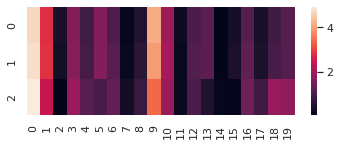

In [117]:
c1 = mean_expression[np.where(pert_list == 'MAPK1+TGFBR2')[0], most_variable_genes[-20:]].reshape(1,-1)
c2 =  mean_expression[np.where(pert_list == 'ctrl+ETS2')[0], most_variable_genes[-20:]].reshape(1,-1)
sns.heatmap(np.concatenate((c1, c2, ctrl[:, most_variable_genes[-20:]])))

In [118]:
i = np.where(pert_list == 'MAPK1+TGFBR2')[0]
pert = mean_expression[i]
print(pert_list[i])

['MAPK1+TGFBR2']


/tmp/ipykernel_50634/3688433631.py:2: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_50634/3688433631.py:2: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl


[Text(0, 0.5, 'MAPK1+TGFBR2'), Text(0, 1.5, 'ctrl')]

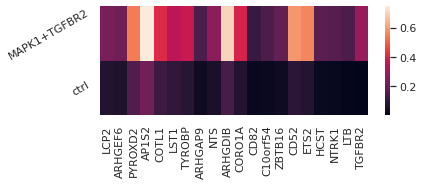

In [148]:
k = 20
fold_change = pert/ctrl
fold_change[np.isnan(fold_change)] = 0
fold_change[np.isinf(fold_change)] = 0

fold_change[0][np.where(pert[0] < 0.1)[0]] = 0

topk_fold_changes = np.argsort(fold_change)[0][-k:]
c1 = pert[:, topk_fold_changes].reshape(1,-1)
c2 = ctrl[:, topk_fold_changes].reshape(1,-1)
ax = sns.heatmap(np.concatenate((c1, c2)))
ax.set_xticklabels(gene_list[topk_fold_changes])
ax.set_yticklabels([pert_list[i][0], 'ctrl'], rotation = 30)

In [149]:
c1

array([[0.22934388, 0.20902088, 0.5396299 , 0.7442049 , 0.4133687 ,
        0.34723297, 0.36835185, 0.14924966, 0.26437858, 0.69880736,
        0.39396968, 0.11326563, 0.15087591, 0.19014075, 0.583543  ,
        0.5586877 , 0.17929384, 0.16862294, 0.15308279, 0.2853028 ]],
      dtype=float32)

In [150]:
c2

array([[0.07148891, 0.06264847, 0.15848711, 0.2167206 , 0.11968527,
        0.09913544, 0.08083089, 0.03265094, 0.05432282, 0.14158419,
        0.07052477, 0.02021107, 0.02495943, 0.03111862, 0.08861561,
        0.07508859, 0.02218506, 0.02042141, 0.01106856, 0.00307668]],
      dtype=float32)

In [154]:
fold_change[0][np.where(gene_list == 'ETS2')[0]]

array([7.4403806], dtype=float32)

In [157]:
gene2status['MAPK1']

'signaling'

In [158]:
gene2status['TGFBR2']

'signaling'

In [159]:
gene2status['ETS2']

'transcription factor'

In [160]:
gene2status['BCL2L11']

'BCL2 family pro-apoptotic'

In [165]:
gene2status['DUSP9']

'signaling'

In [166]:
gene2status['IGDCC3']

'immunoglobulin DCC subtype'

In [169]:
gene2status['SNAI1']

'transcription factor'

In [176]:
from utils import parse_single_pert, parse_any_pert

In [174]:
corr_fold_changes = []
for c in form_AB_C:
    q1 = c[0]
    q2 = c[1]
    
    i = np.where(pert_list == q1)[0]
    pert = mean_expression[i]
    
    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    fold_change[0][np.where(pert[0] < 0.1)[0]] = 0
    fc = fold_change[0][np.where(gene_list == parse_single_pert(q2))[0]]
    
    corr_fold_changes.append((fc[0], c[2]))

/tmp/ipykernel_50634/1744984347.py:9: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_50634/1744984347.py:9: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl


In [175]:
corr_fold_changes

[(0.0, 0.3523299818794149),
 (0.0, 0.6857607274776449),
 (0.0, 0.8779019780110475),
 (6.228314, 0.8337438300302283),
 (0.0, 0.9459044940236668),
 (0.0, 0.9450568814100481),
 (0.0, 0.9265882308117831),
 (0.0, 0.9262205916083754),
 (0.0, 0.7880293527700989),
 (0.0, 0.8570524822236342),
 (0.0, 0.7996935838759098),
 (0.0, 0.7995353929762368),
 (0.8855235, 0.7841776025156834),
 (0.8855235, 0.7803504300888134),
 (3.0527685, 0.9354845938615464),
 (3.0527685, 0.9354176324036135),
 (23.761322, 0.8154604060988084),
 (1.6325972, 0.6317409516808135),
 (0.0, 0.8889870382378344),
 (0.0, 0.8846717759603488),
 (0.0, 0.5541335212725205),
 (0.0, 0.7404815124117897),
 (0.0, 0.7593659002942127),
 (0.0, 0.7391185919257972),
 (0.984871, 0.558469704875895),
 (7.4403806, 0.9314792135449927),
 (7.4403806, 0.9204283415329652),
 (0.0, 0.674186951565633),
 (0.0, 0.874822568078057),
 (1.1026132, 0.6937735420993153),
 (0.0, 0.6898264549412313),
 (0.0, 0.8749178401903432),
 (0.9332959, 0.8111119211411146),
 (0.93329

In [257]:
from scipy import stats

def get_fc_AB_C(c):    

    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]
    
    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    
    topk_fold_changes = np.argsort(fold_change)[0][-k:]
    c1 = pert[:, topk_fold_changes].reshape(1,-1)
    c2 = ctrl[:, topk_fold_changes].reshape(1,-1)
    topk_fc_genes = gene_list[topk_fold_changes]
    
    for x in topk_fc_genes:
        for c2 in pert_list:
            if c!=c2 and c2 != 'ctrl' and len(np.intersect1d(parse_any_pert(c), parse_any_pert(c2)))==0:
                parse = parse_any_pert(c2)
                if x in parse and len(parse) == 1:
                    c2_exp = mean_expression[np.where(pert_list == c2)[0]]
                    fc = fold_change[0][np.where(gene_list == parse[0])[0]]
                    if fc[0] > 5:
                        corr_fc.append((c, c2, fc[0], 
                                    stats.pearsonr(c2_exp[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0], 
                                                   pert[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0])[0],
                                    stats.spearmanr(c2_exp[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0], 
                                                    pert[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0])[0]))
                    
    return corr_fc

In [258]:
from tqdm import tqdm
corr_fc = []
for c in tqdm(pert_list):
    if c!='ctrl':
        a = get_fc_AB_C(c)

  0%|                                                                                                                                                                                                       | 0/284 [00:00<?, ?it/s]/tmp/ipykernel_50634/1485303386.py:8: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_50634/1485303386.py:8: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:38<00:00,  7.37it/s]


/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


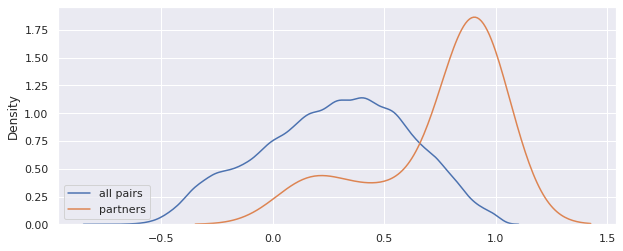

In [263]:
sns.set(rc={'figure.figsize':(10, 4)})
import matplotlib.pyplot as plt
corr = pd.DataFrame(mean_expression[:, most_variable_genes] - ctrl[:, most_variable_genes]).T.corr('pearson').values
sns.distplot(corr.reshape(-1,), hist = False, label = 'all pairs')
ax = sns.distplot([i[3] for i in corr_fc], hist = False, label = 'partners')
#ax.set_xlim(0, 1)
plt.legend(loc='lower left', labels=['all pairs', 'partners'])


In [271]:
df_corr_fc = pd.DataFrame(corr_fc)

In [272]:
df_corr_fc = df_corr_fc.rename(columns = {0: 'query_pert', 1: 'act_pert', 
                             2: 'fold_change', 3: 'pearson', 4: 'spearman'})

In [273]:
def gene2type(c):
    out = []
    o = parse_any_pert(c)
    for i in o:
        if i in gene2status:
            out.append(gene2status[i])
        else:
            out.append('N/A')
            
    return '+'.join(out)

In [274]:
df_corr_fc['query_type'] = df_corr_fc.query_pert.apply(lambda x: gene2type(x))
df_corr_fc['act_type'] = df_corr_fc.act_pert.apply(lambda x: gene2type(x))

In [275]:
df_corr_fc

,query_pert,act_pert,fold_change,pearson,spearman,query_type,act_type
0,DUSP9+MAPK1,ctrl+ETS2,7.202773,0.224872,0.367251,signaling+signaling,transcription factor
1,DUSP9+MAPK1,ETS2+ctrl,7.202773,0.211482,0.334171,signaling+signaling,transcription factor
2,IGDCC3+MAPK1,ctrl+ETS2,6.974825,0.531236,0.601059,immunoglobulin DCC subtype+signaling,transcription factor
3,IGDCC3+MAPK1,ETS2+ctrl,6.974825,0.515201,0.570700,immunoglobulin DCC subtype+signaling,transcription factor
4,JUN+CEBPA,ctrl+CEBPE,46.594349,0.910482,0.939818,transcription factor+transcription factor,transcription factor
5,JUN+CEBPA,CEBPE+ctrl,46.594349,0.890260,0.926303,transcription factor+transcription factor,transcription factor
6,MAPK1+IKZF3,ctrl+ETS2,6.793534,0.120023,0.401845,signaling+transcription factor,transcription factor
7,MAPK1+IKZF3,ETS2+ctrl,6.793534,0.101036,0.370752,signaling+transcription factor,transcription factor
8,CEBPB+CEBPA,ctrl+CEBPE,57.989193,0.904909,0.939067,transcription factor+transcription factor,transcription factor
9,CEBPB+CEBPA,CEBPE+ctrl,57.989193,0.886019,0.926767,transcription factor+transcription factor,transcription factor


## Can two perturbations lead to the same surprise genes?

In [305]:
fold_change_all = []
for c in pert_list:
    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]

    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    fold_change_all.append(fold_change[0])
    
fold_change_all = np.stack(fold_change_all)


/tmp/ipykernel_50634/283273026.py:6: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_50634/283273026.py:6: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl


In [321]:
surprise2pert = {}
for gene in range(len(gene_list)):
    #Q1 = np.percentile(fold_change_all[:, gene], 25)
    #Q3 = np.percentile(fold_change_all[:, gene], 75)
    #IQR = Q3 - Q1
    #upper = Q3 + 10*IQR
    upper = 5
    perts = pert_list[np.where(fold_change_all[:, gene] > upper)[0]]
    if len(perts) != 0:
        surprise2pert[gene_list[gene]] = perts

In [353]:
gene2corr_group = {}
for s, pert in surprise2pert.items():
    if len(pert) > 1:
        m_exp = mean_expression[np.isin(pert_list, pert)]
        m = np.sum(pd.DataFrame(m_exp[:, most_variable_genes] - ctrl[:, most_variable_genes]).T.corr('pearson').values.reshape(-1,))
        m = (m - len(pert))/(len(pert)*len(pert)-len(pert))
        gene2corr_group[s] = m

In [351]:
pert

array(['JUN+CEBPA', 'CEBPB+CEBPA', 'FOSB+CEBPE', 'ctrl+CEBPA',
       'FOSB+CEBPB', 'KLF1+CEBPA', 'CEBPE+CEBPA', 'CEBPA+ctrl',
       'CEBPE+SPI1', 'CEBPE+CEBPB', 'ZC3HAV1+CEBPA'], dtype='<U15')

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


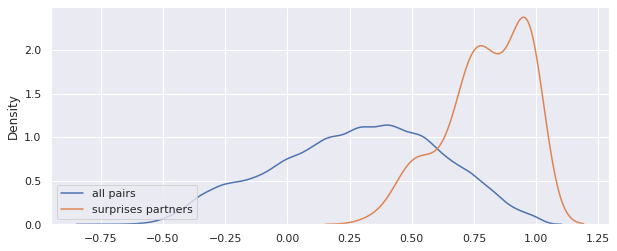

In [354]:
sns.set(rc={'figure.figsize':(10, 4)})
corr = pd.DataFrame(mean_expression[:, most_variable_genes] - ctrl[:, most_variable_genes]).T.corr('pearson').values
sns.distplot(corr.reshape(-1,), hist = False, label = 'all pairs')
ax = sns.distplot(list(gene2corr_group.values()), hist = False, label = 'partners')
#ax.set_xlim(0, 1)
plt.legend(loc='lower left', labels=['all pairs', 'surprises partners'])

## for each perturbation, look at high fold changes genes => the high fold change genes correspond to the unseen perturbations that perfrom well?

In [462]:
fold_change_all = []
for c in pert_list:
    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]

    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    #fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    fold_change_all.append(fold_change[0])
    
fold_change_all = np.stack(fold_change_all)


/tmp/ipykernel_50634/1466758563.py:6: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_50634/1466758563.py:6: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl


In [360]:
combo_seen0 = pertdl.subgroup['test_subgroup']['combo_seen0']
unseen_single = pertdl.subgroup['test_subgroup']['unseen_single']

In [361]:
train_perts = pertdl.set2conditions['train']

In [512]:
train_pert = train_perts[0]
pert2high_folds_up = {}
pert2low_folds_down = {}

for train_pert in train_perts:
    temp = np.where(pert_list == train_pert)[0]
    o = np.intersect1d(np.where(fold_change_all[temp][0] <0.333)[0], np.where(fold_change_all[temp][0] > 0)[0])
    if len(o) > 0:
        pert2low_folds_down[train_pert] = gene_list[o].tolist()
        
    o = np.where(fold_change_all[np.where(pert_list == train_pert)[0]][0] >3)[0]
    if len(o) > 0:
        pert2high_folds_up[train_pert] = gene_list[o].tolist()

In [513]:
all_high_folds = []
for i in pert2high_folds_up.values():
    all_high_folds = all_high_folds + i
    
all_high_folds_down = []
for i in pert2low_folds_down.values():
    all_high_folds_down = all_high_folds_down + i

In [514]:
all_high_folds = np.unique(all_high_folds)
all_high_folds_down = np.unique(all_high_folds_down)

In [515]:
unseen_single_gene = [parse_single_pert(i) for i in unseen_single]
genesymbol2pert = dict(zip(unseen_single_gene, unseen_single))

In [516]:
len(np.unique(np.intersect1d(unseen_single_gene, all_high_folds)))

5

In [517]:
len(np.unique(np.intersect1d(unseen_single_gene, all_high_folds_down)))

7

In [518]:
len(np.unique(unseen_single_gene))

27

In [519]:
up_overlap = np.intersect1d(unseen_single_gene, all_high_folds)
down_overlap = np.intersect1d(unseen_single_gene, all_high_folds_down)

In [520]:
non_overlap = np.setdiff1d(unseen_single_gene, up_overlap.tolist() + down_overlap.tolist())

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

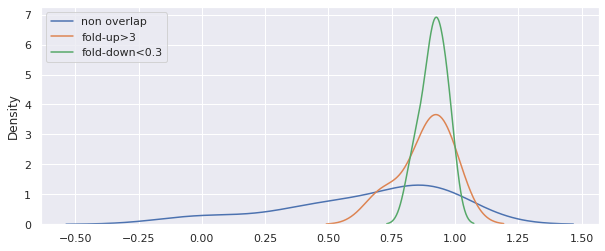

In [522]:
ax = sns.distplot([test_pert_res[genesymbol2pert[i]]['spearman_de'] for i in non_overlap], hist = False, label = 'partners')
ax = sns.distplot([test_pert_res[genesymbol2pert[i]]['spearman_de'] for i in up_overlap], hist = False, label = 'partners')
ax = sns.distplot([test_pert_res[genesymbol2pert[i]]['spearman_de'] for i in down_overlap], hist = False, label = 'partners')
plt.legend(loc='upper left', labels=['non overlap', 'fold-up>3', 'fold-down<0.3'])

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

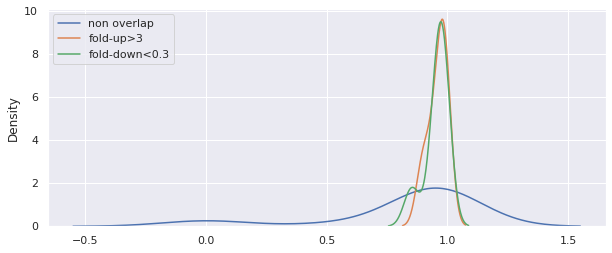

In [610]:
ax = sns.distplot([test_pert_res[genesymbol2pert[i]]['pearson_de'] for i in non_overlap], hist = False, label = 'partners')
ax = sns.distplot([test_pert_res[genesymbol2pert[i]]['pearson_de'] for i in up_overlap], hist = False, label = 'partners')
ax = sns.distplot([test_pert_res[genesymbol2pert[i]]['pearson_de'] for i in down_overlap], hist = False, label = 'partners')
plt.legend(loc='upper left', labels=['non overlap', 'fold-up>3', 'fold-down<0.3'])

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

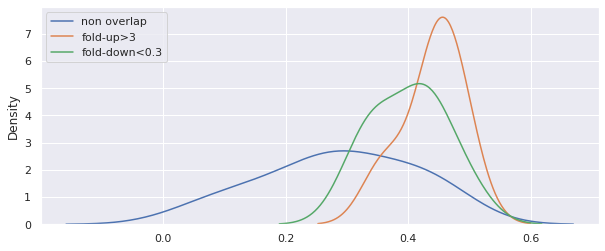

In [542]:
ax = sns.distplot([metrics_pert_delta[genesymbol2pert[i]]['pearson'] for i in non_overlap], hist = False, label = 'partners')
ax = sns.distplot([metrics_pert_delta[genesymbol2pert[i]]['pearson'] for i in up_overlap], hist = False, label = 'partners')
ax = sns.distplot([metrics_pert_delta[genesymbol2pert[i]]['pearson'] for i in down_overlap], hist = False, label = 'partners')
plt.legend(loc='upper left', labels=['non overlap', 'fold-up>3', 'fold-down<0.3'])

In [ ]:
## calculate the MSE on the most fold-changed genes

In [557]:
fold_change_all = []
for c in pert_list:
    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]

    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    #fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    fold_change_all.append(fold_change[0])
    
fold_change_all = np.stack(fold_change_all)

/tmp/ipykernel_50634/1129557839.py:6: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_50634/1129557839.py:6: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl


In [563]:
most_up_fold_changes = np.argsort(fold_change_all, axis = 1)[:, -20:]

In [571]:
metrics_pert = {}
metric2fct = {
           'mse': mse,
           'mae': mae,
           'spearman': spearmanr,
           'pearson': pearsonr,
           'r2': r2_score
    }

for pert in np.unique(results['pert_cat']):
    pert_idx = np.where(pert_list == pert)[0]
    metrics_pert[pert] = {}
    p_idx = np.where(results['pert_cat'] == pert)[0]
    for m, fct in metric2fct.items():
        if m in ['spearman', 'pearson']:
            val = fct(results['pred'][p_idx].mean(0)[most_up_fold_changes[pert_idx]][0], results['truth'][p_idx].mean(0)[most_up_fold_changes[pert_idx]][0])[0]
            if np.isnan(val):
                val = 0
        else:
            val = fct(results['pred'][p_idx].mean(0)[most_up_fold_changes[pert_idx]][0], results['truth'][p_idx].mean(0)[most_up_fold_changes[pert_idx]][0])

        metrics_pert[pert][m] = val

In [572]:
metrics_pert

{'AHR+KLF1': {'mse': 0.042373978,
  'mae': 0.18955599,
  'spearman': 0.8330827067669173,
  'pearson': 0.9239012904010555,
  'r2': -1.7569045346711367},
 'ARID1A+ctrl': {'mse': 0.0051933294,
  'mae': 0.0662009,
  'spearman': 0.6992481203007518,
  'pearson': 0.7758224239258439,
  'r2': -4.019838323613244},
 'BCL2L11+BAK1': {'mse': 0.0025984803,
  'mae': 0.049365528,
  'spearman': 0.07148233776770777,
  'pearson': 0.2786967434534955,
  'r2': -14.426605948791185},
 'BCL2L11+TGFBR2': {'mse': 0.007240744,
  'mae': 0.072874166,
  'spearman': 0.0781954887218045,
  'pearson': 0.9806478090285488,
  'r2': -0.09910390652131751},
 'BCL2L11+ctrl': {'mse': 0.004988016,
  'mae': 0.06974552,
  'spearman': 0.5979692036263639,
  'pearson': 0.32822068093687573,
  'r2': -37.19572514672425},
 'BCORL1+ctrl': {'mse': 0.004505083,
  'mae': 0.06689688,
  'spearman': 0.4300751879699248,
  'pearson': 0.6161351026963698,
  'r2': -96.12192780031025},
 'BPGM+SAMD1': {'mse': 0.008383729,
  'mae': 0.07667846,
  'spear

In [568]:
most_up_fold_changes

array([[1501,  777, 4270, ..., 4679,  305,  808],
       [4745, 2006,  212, ..., 2032, 2836, 4259],
       [2425, 2426, 2427, ..., 2443, 2430, 2522],
       ...,
       [2736, 3815, 2009, ..., 2339, 4710,  830],
       [2844,  916, 3339, ..., 1699, 2339, 1855],
       [2532, 4387, 1399, ..., 1953, 2925, 4775]])

In [7]:
want = {}

for i in ['CBL+CNN1', 'DUSP9+ETS2']:
    query_idx = np.where(test_res['pert_cat'] == i)[0]
    want[i] = {"query": i, 
            "pred_de": test_res['pred_de'][query_idx],
            "truth_de": test_res['truth_de'][query_idx]
              }

In [8]:
import pickle
pickle.dump(want, open('viz_interaction.pkl', 'wb'))

In [9]:
for i in ['CBL+CNN1', 'DUSP9+ETS2']:

    print(test_pert_res[i])

{'mse': 0.015092794, 'mae': 0.08204727, 'spearman': 0.8261467992690825, 'pearson': 0.9683605728653688, 'r2': 0.8981752308562897, 'mse_de': 0.69507796, 'mae_de': 0.7207664, 'spearman_de': 0.9067669172932331, 'pearson_de': 0.9121423201945077, 'r2_de': -0.21185414728369056}
{'mse': 0.016402414, 'mae': 0.10711804, 'spearman': 0.8687508292518453, 'pearson': 0.979097807082659, 'r2': 0.8844600659445081, 'mse_de': 0.31558293, 'mae_de': 0.50120467, 'spearman_de': 0.8616541353383457, 'pearson_de': 0.9191062556783037, 'r2_de': 0.7264653755145475}


In [20]:
pickle.dump(test_pert_res, open('./gnn_disentangle_test_pert_res.pkl', 'wb'))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [21]:
cpa_test_pert_res = pickle.load(open('./CPA/cpa_test_pert_res.pkl', 'rb'))

In [31]:
res_cpa = {}
for i,j in cpa_test_pert_res.items():
    res_cpa[i] = {'mse_de_cpa': j['mse_de']}
    
res_gnn = {}
for i,j in test_pert_res.items():
    res_gnn[i] = {'mse_de_gnn': j['mse_de']}

In [33]:
import pandas as pd
df_eval = pd.DataFrame(res_cpa).T

In [34]:
df_eval['mse_de_gnn'] = pd.DataFrame(res_gnn).T['mse_de_gnn'].values

In [35]:
df_eval

,mse_de_cpa,mse_de_gnn
AHR+KLF1,0.357695,0.368303
ARID1A+ctrl,0.258422,0.211488
BCL2L11+BAK1,0.004903,0.038742
BCL2L11+TGFBR2,0.052947,0.062958
BCL2L11+ctrl,0.014018,0.017545
...,...,...
ctrl+ISL2,0.030616,0.088716
ctrl+MAP7D1,0.059880,0.041222
ctrl+PTPN12,0.137781,0.125480
ctrl+SET,0.464519,0.356826


In [37]:
subgroup = pickle.load(open('./splits/Norman2019_simulation_1_0.1_subgroup.pkl', 'rb'))

In [39]:
subgroup = subgroup['test_subgroup']

In [41]:
pert2group = {}
for i,j in subgroup.items():
    for x in j:
        pert2group[x] = i

In [44]:
df_eval['group'] = [pert2group[x] for x in df_eval.index.values]

In [46]:
df_eval[df_eval.group == 'combo_seen2']

,mse_de_cpa,mse_de_gnn,group
AHR+KLF1,0.357695,0.368303,combo_seen2
CEBPE+RUNX1T1,0.100133,0.339434,combo_seen2
CNN1+MAPK1,0.078004,0.113659,combo_seen2
CNN1+UBASH3A,0.783318,0.708051,combo_seen2
ETS2+CNN1,0.133394,0.093787,combo_seen2
ETS2+IKZF3,0.310006,0.968617,combo_seen2
ETS2+MAPK1,0.355581,0.954693,combo_seen2
FOSB+IKZF3,0.356463,0.507040,combo_seen2
FOSB+UBASH3B,0.050452,0.069400,combo_seen2
FOXA1+HOXB9,0.180823,0.211096,combo_seen2


In [47]:
df_eval.to_csv('./cpa_gnn_comparison.csv', index = False)